In [ ]:
# Wrangling images

import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#set up your local datapath
from google.colab import drive
drive.mount('/content/drive')
#change this based on your setup
root = '/content/drive/MyDrive/Colab/ML/'
datapath =  root + 'data/'

Mounted at /content/drive


In [3]:
import cv2
import numpy
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from google.colab.patches import cv2_imshow

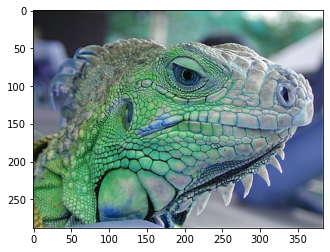

In [5]:
#display an image
input_image_color = 'reptile_color.jpg'
image = cv2.imread(datapath + input_image_color)
plt.imshow(image)

In [27]:
#get the dimensions of an image
size = image.size
dimensions = image.shape
print(dimensions, size)
print('height: ', dimensions[0])
print('width: ', dimensions[1])
print('number of bands: ', dimensions[2])

(288, 384, 3) 331776
height:  288
width:  384
number of bands:  3


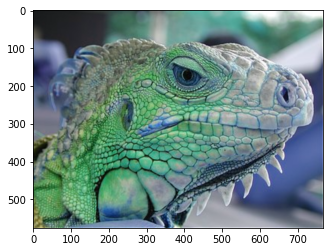

In [12]:
#resize an image
n = 2
interpolation_method = cv2.INTER_LINEAR
new_height = n*dimensions[0]
new_width = n*dimensions[1]
bigger_image = cv2.resize(image, (new_width, new_height), interpolation_method)
plt.imshow(bigger_image)

In [29]:
#split color image into bands, and find the dimensions
b,g,r = cv2.split(image) #returns numpy matrix
print (b.shape)

(288, 384)


In [ ]:
#pad an image with extra data (zeros)

In [34]:
#basic use of numpy.pad
# https://sparrow.dev/numpy-pad/
x = numpy.ones(3)
y = numpy.pad(x, pad_width=1)
print(x)
print(y)

[1. 1. 1.]
[0. 1. 1. 1. 0.]


In [37]:
#on a matrix
x = numpy.ones((3, 3))
y = numpy.pad(x, pad_width=1)
print(x)
print(y)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]


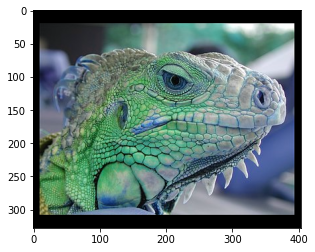

In [47]:
#pad around the image as required
p = 10
extra_left, extra_right = p,p
extra_top, extra_bottom = 2*p, 2*p 
padded_image = numpy.pad(image, ((extra_top, extra_bottom), (extra_left, extra_right), (0, 0)), mode='constant', constant_values=0) 
plt.imshow(padded_image)

In [49]:
#compare original and padded image
print(image.shape)
print(padded_image.shape)

(288, 384, 3)
(328, 404, 3)


In [51]:
# The opposite of padding is cropping
input_image_color = 'reptile_color.jpg'
image = cv2.imread(datapath + input_image_color)
dimensions = image.shape
print(dimensions)

(288, 384, 3)


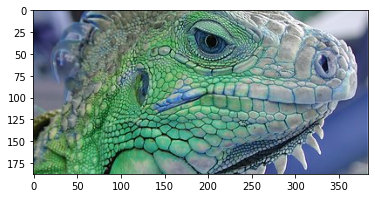

In [55]:
# Crop top and bottom

cut = 50
top = cut
bottom = dimensions[0] - cut
cropped_image = image[top:bottom, 0:dimensions[1]]
plt.imshow(cropped_image)

In [ ]:
# YOUR TASK
# create a function that takes in two images and adjusts the size of one image to the other
#if the flag = crop, then crop the larger of the two images to the dimensions of the smaller image
#if the flag = pad, then pad the smaller of the two images to the dimensions of the larger image
#to keep things easy, the input images differ in both height and width

# Psydo code for the function
def adjust_image(image1, image2, adjustment):
  #get dimensions of image 1
  #get dimensions of image 2
  #if height of image 1 > height of image 2 and adjustment is crop
  #then perform crop on image 1
  #if height of image 1 > height of image2 and adjustment is pad
  #then perform pad on image 2
  #return the altered image


In [ ]:
#PROCESS
#1) read in image 1
#2) read in image 2
#3) select adjustment (adjustment = crop or adjustment = pad)
#4) call adjust_image
#5) compare dimensions of image 1, image 2, altered image

In [ ]:
# Show color bands
# https://www.gimp.org/tutorials/Color2BW/

b = image.copy()
# set green and red channels to 0
b[:, :, 1] = 0
b[:, :, 2] = 0

g = image.copy()
# set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

r = image.copy()
# set blue and green channels to 0
r[:, :, 0] = 0
r[:, :, 1] = 0

gamma = 0.5
weight_1 = 0.5
weight_2 = 1 - weight_1
mix = cv2.addWeighted(b, weight_1, r, weight_2, gamma)


figure(figsize=(30, 15), dpi=80)
images = [r,b,g, mix]
for i in range(0,4):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    output = 'color_ ' + str(i) + '.png'
    cv2.imwrite(datapath + output, images[i])

In [ ]:
#---------------------------------------------------------------------------

Now we will color the gray scale image with a neural net trained on other color images


In [ ]:
# Paths to model files
proto_file = modelpath + 'colorization_deploy_v2.prototxt'
model_file = modelpath + 'colorization_release_v2.caffemodel'
hull_pts = modelpath + 'pts_in_hull.npy'

In [ ]:
# Model parameters
net = cv2.dnn.readNetFromCaffe(proto_file, model_file)
kernel = numpy.load(hull_pts)

In [ ]:
# Read in the image
input_image = 'reptile.jpg'
img_path = datapath + input_image
img = cv2.imread(img_path)
scaled = img.astype("float32") / 255.0
lab_img = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

In [ ]:
# Add the cluster centers as 1x1 convolutions to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = kernel.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [numpy.full([1, 313], 2.606, dtype="float32")]

# Resize the image for the network
resized = cv2.resize(lab_img, (224, 224))
# Split the L channel
L = cv2.split(resized)[0]
# mean subtraction
L -= 50

In [ ]:
# Predict the ab channels from the input L channel
net.setInput(cv2.dnn.blobFromImage(L))
ab_channel = net.forward()[0, :, :, :].transpose((1, 2, 0))
# Resize the predicted 'ab' volume to the same dimensions as our input image
ab_channel = cv2.resize(ab_channel, (img.shape[1], img.shape[0]))
 
# Take the L channel from the image
L = cv2.split(lab_img)[0]
# Join the L channel with predicted ab channel
colorized = numpy.concatenate((L[:, :, numpy.newaxis], ab_channel), axis=2)
 
# Convert the image from Lab to BGR
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = numpy.clip(colorized, 0, 1)

In [ ]:
# Change the image to 0-255 range and convert it from float32 to int
colorized = (255 * colorized).astype("uint8")
 
# Resize the images and show them together
img = cv2.resize(img,(640,640))
colorized = cv2.resize(colorized,(640,640))
result = cv2.hconcat([img,colorized])
 
# Display result
figure(figsize=(30, 15), dpi=80)
plt.imshow(result)

Output hidden; open in https://colab.research.google.com to view.